**Interpreting Permutation Importances**
- The values towards the top are the most important features, and those towards the bottom matter least.

- The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

- Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

- You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

- In our example, the most important feature was Goals scored. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

**要は、特徴量の列をシャッフルすることで、精度がどの程度落ちているかチェエク**

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('../../datasets/fifa/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())


Using TensorFlow backend.


Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


**Partial Dependence Plots**
- While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

- This is useful to answer questions like:

- Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

- Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

- If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models. If you aren't familiar with linear or logistic regressions, don't worry about this comparison.

- We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

**要は、特徴量が全体の予測結果にどの程度影響を与えるかを調べるために、特定のサンプル（群）における特徴量を変化させてみた。**
- どうやって変化させているのかはしらないけど、オプションで変化できるらしい

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('../../datasets/fifa/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

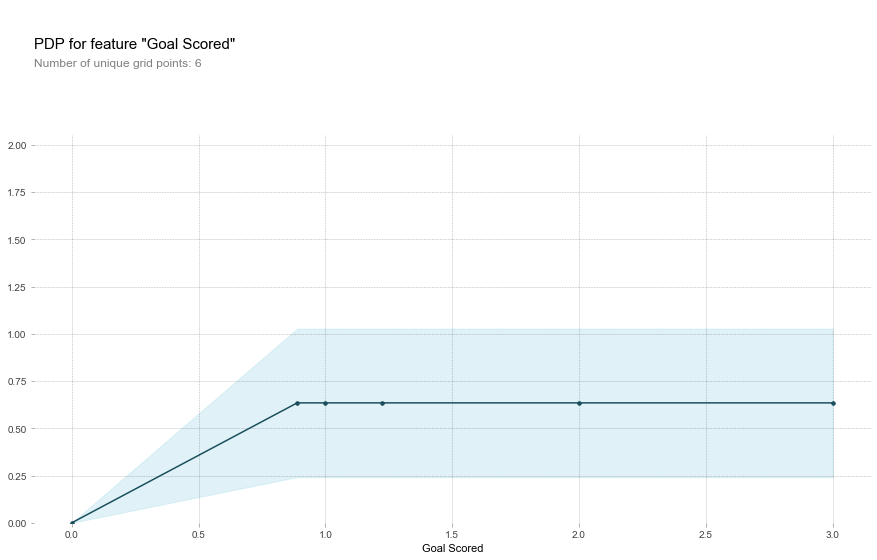

In [14]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

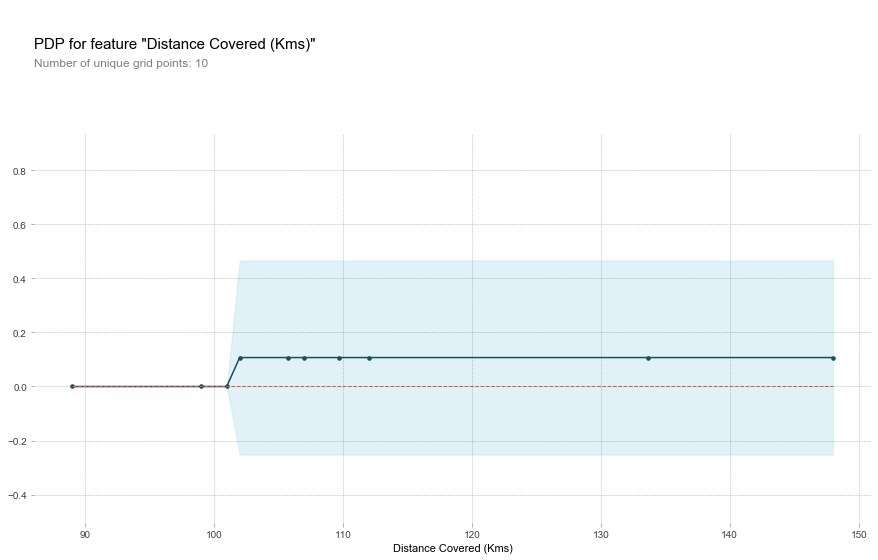

In [15]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

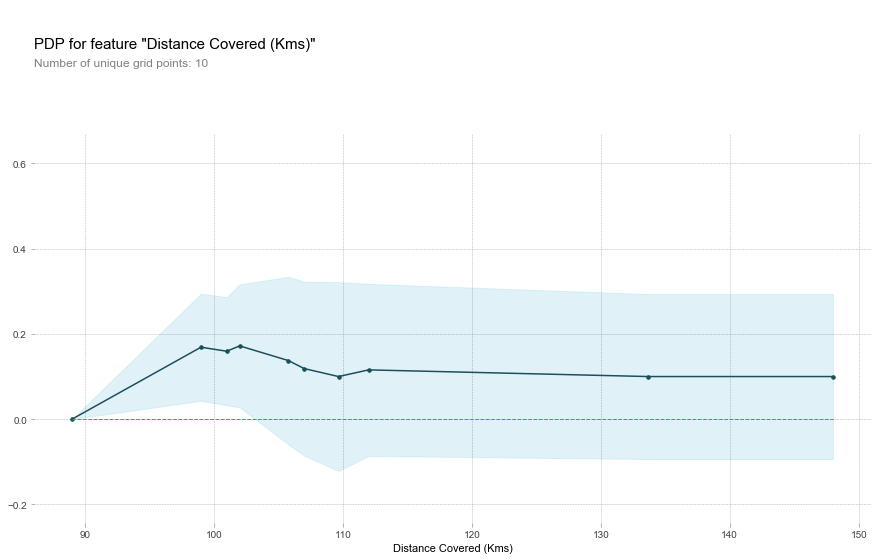

In [16]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

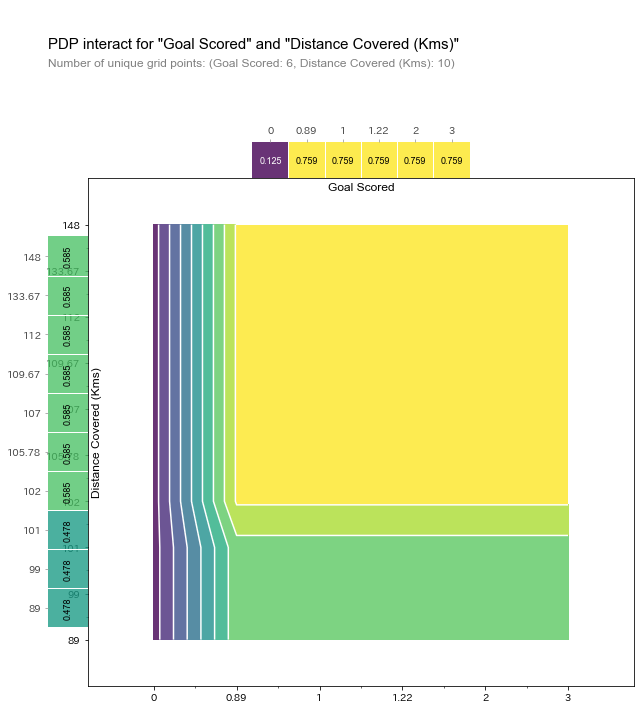

In [18]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', plot_pdp=True)
plt.show()

### SHAP

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('../../datasets/fifa/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [21]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

array([[0.3, 0.7]])

In [33]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

# aggregation og shap

In [35]:
The code isn't too complex. But there are a few caveats.

When plotting, we call shap_values[1]. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an xgboost model, which SHAP has some optimizations for and which is thus much faster.
This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

SHAP Dependence Contribution Plots
We've previously used Partial Dependence Plots to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show. For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

SyntaxError: invalid syntax (<ipython-input-35-d3ed6d5e084d>, line 1)

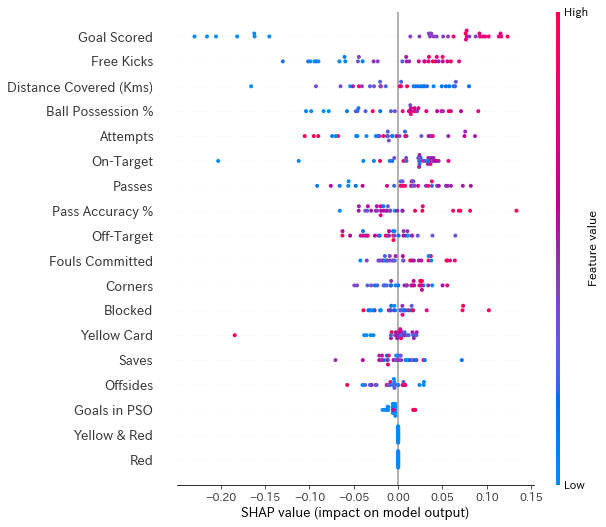

In [36]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

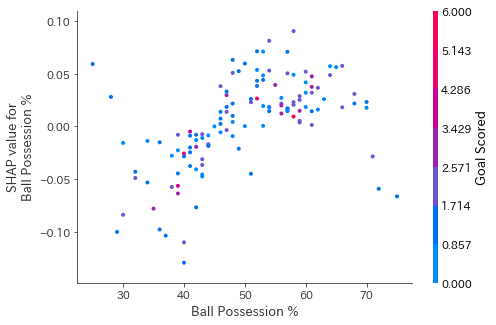

In [37]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

In [38]:
SHAP依存寄与プロット
以前は、単一の特徴が予測にどのように影響するかを示すために、部分依存プロットを使用しました。これらは洞察力に富み、多くの実際のユースケースに関連しています。さらに、少しの努力で、技術に詳しくない聴衆に説明することができます。

しかし、彼らが見せないものはたくさんあります。たとえば、効果の分布は何ですか？特定の値を持つことの効果はかなり一定ですか、または他の機能の値に応じて大きく変化します。 SHAP依存性寄与プロットは、PDPと同様の洞察を提供しますが、より多くの詳細を追加します。

形状に焦点を当てることから始めましょう。すぐに色に戻ります。各ドットは、データの行を表します。水平位置はデータセットからの実際の値であり、垂直位置はその値が予測にどのような影響を与えたかを示しています。この傾斜が上向きであるという事実は、あなたがボールを所有するほど、モデルの予想はマンオブザマッチ賞を獲得するために高くなることを意味します。

この広がりは、他の機能がボール所有率と相互作用する必要があることを示唆しています。たとえば、ここでは、ボール所有値が似ている2つのポイントを強調表示しています。その値により、一方の予測が増加し、他方の予測が減少しました。

比較のために、単純な線形回帰では、この広がりのない完全な線のプロットが生成されます。

これは、相互作用を詳しく調べることを示唆しており、プロットにはそのための色分けが含まれています。主な傾向は上昇していますが、ドットの色によって変化するかどうかを視覚的に調べることができます。

具体性については、次の非常に狭い例を検討してください。

これらの2つのポイントは、上昇傾向から遠く離れているため、空間的に際立っています。どちらも紫色で表示され、チームが1つのゴールを決めたことを示します。これを解釈すると、一般的に、ボールを持っていると、チームが選手に賞を獲得するチャンスが増えます。しかし、得点が1つだけの場合、その傾向は逆転し、賞の審査員は、得点が少ない場合、ボールをたくさん持っていることでペナルティを科す可能性があります。

これらのわずかな外れ値以外では、色で示される相互作用はここではそれほど劇的ではありません。しかし、時にはそれはあなたに飛び出します。

コードの依存性寄与プロット
次のコードで依存性寄与プロットを取得します。 summary_plotと異なる唯一の行は最後の行です。

SyntaxError: invalid character in identifier (<ipython-input-38-459e490f02df>, line 2)